In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import utils

In [2]:
def get_CCF(line_species, name='Luhman 16A'):

    if name == 'Luhman 16A':
        prefix='../retrieval_outputs/new_fiducial_K_A_ret_9/test_'; m_set='K2166_A'
    elif name == 'Luhman 16B':
        prefix='../retrieval_outputs/new_fiducial_K_B_ret_6/test_'; m_set='K2166_B'

    Res_i = utils.RetrievalResults(
        prefix=prefix, m_set=m_set, w_set='K2166', load_posterior=True, verbose=False
        )

    # Template spectrum w/o that species
    wave, flux_wo_species = Res_i.get_model_spec(
        is_local=False, # Rotationally broadened
        line_species_to_exclude=line_species, 
        return_wave_flux=True, 
        )
    # Template spectrum of a single species
    '''
    _, flux_local = Res_i.get_model_spec(
        is_local=False, # Rotationally broadened
        line_species_to_include=line_species, 
        return_wave_flux=True, 
        )
    '''
    _, flux_local = Res_i.get_model_spec(is_local=False, return_wave_flux=True)

    # Compute cross-correlation
    rv, _, CCF_SNR = Res_i.get_CCF(
        wave, flux_local, # Model template
        rv=np.arange(-1000,1000+1e-6,1), 
        model_to_subtract_from_d_res=flux_wo_species, #model_to_subtract_from_d_res=None, 
        #model_to_subtract_from_m_res=None, 
        model_to_subtract_from_m_res=flux_wo_species, 
        high_pass={
            'm_res': utils.high_pass_filter(window_length=301), # Filter on model
            'd_res': utils.high_pass_filter(window_length=301), # Filter on data
            }, 
        #plot=True, 
        rv_sep=300, # Separation to calculate std-dev from
        )
    
    return Res_i, rv, CCF_SNR

CCF_SNR_A = {
    #'H2O_pokazatel_main_iso_Sam_new': None, 
    'H2O_181_HotWat78': None, 

    #'CO_high_Sam': None, 
    'CO_36_high_Sam': None, 
    'CO_28_high_Sam': None, 

    'CH4_MM_main_iso': None, 
    'NH3_coles_main_iso_Sam': None, 
    'H2S_Sid_main_iso': None, 
    'HF_main_iso_new': None, 
}
CCF_SNR_B = CCF_SNR_A.copy()

for line_species_j in CCF_SNR_A.keys():

    try: 
        del Res_A
    except:
        pass

    try: 
        del Res_B
    except:
        pass

    Res_A, rv, CCF_SNR_A[line_species_j] = get_CCF(line_species_j, name='Luhman 16A')
    Res_B, rv, CCF_SNR_B[line_species_j] = get_CCF(line_species_j, name='Luhman 16B')

  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_9/test_.txt
Generating a model w/o H2O_181_HotWat78


100%|██████████| 2001/2001 [00:12<00:00, 154.93it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_B_ret_6/test_.txt
Generating a model w/o H2O_181_HotWat78


100%|██████████| 2001/2001 [00:14<00:00, 142.46it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_9/test_.txt
Generating a model w/o CO_36_high_Sam


100%|██████████| 2001/2001 [00:13<00:00, 148.71it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_B_ret_6/test_.txt
Generating a model w/o CO_36_high_Sam


100%|██████████| 2001/2001 [00:13<00:00, 147.27it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_9/test_.txt
Generating a model w/o CO_28_high_Sam


100%|██████████| 2001/2001 [00:14<00:00, 141.86it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_B_ret_6/test_.txt
Generating a model w/o CO_28_high_Sam


100%|██████████| 2001/2001 [00:13<00:00, 150.60it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_9/test_.txt
Generating a model w/o CH4_MM_main_iso


100%|██████████| 2001/2001 [00:13<00:00, 149.27it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_B_ret_6/test_.txt
Generating a model w/o CH4_MM_main_iso


100%|██████████| 2001/2001 [00:14<00:00, 141.84it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_9/test_.txt
Generating a model w/o NH3_coles_main_iso_Sam


100%|██████████| 2001/2001 [00:13<00:00, 152.15it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_B_ret_6/test_.txt
Generating a model w/o NH3_coles_main_iso_Sam


100%|██████████| 2001/2001 [00:12<00:00, 156.04it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_9/test_.txt
Generating a model w/o H2S_Sid_main_iso


100%|██████████| 2001/2001 [00:13<00:00, 149.00it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_B_ret_6/test_.txt
Generating a model w/o H2S_Sid_main_iso


100%|██████████| 2001/2001 [00:13<00:00, 149.74it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_9/test_.txt
Generating a model w/o HF_main_iso_new


100%|██████████| 2001/2001 [00:13<00:00, 143.98it/s]


  analysing data from ../retrieval_outputs/new_fiducial_K_B_ret_6/test_.txt
Generating a model w/o HF_main_iso_new


100%|██████████| 2001/2001 [00:13<00:00, 150.66it/s]


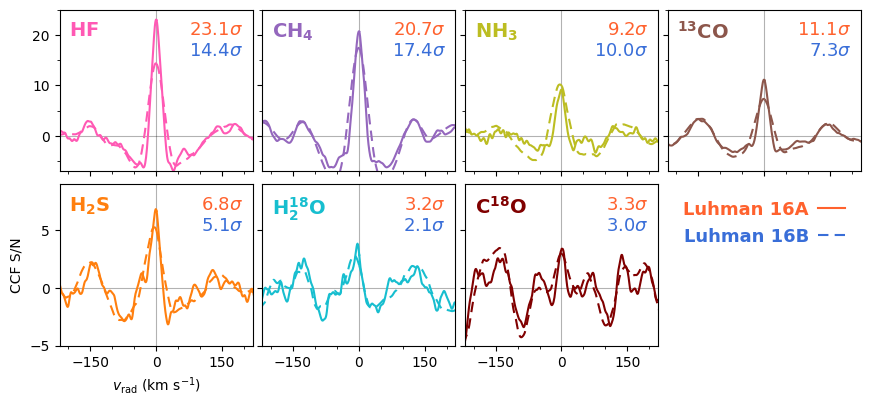

In [165]:
color_m_A = '#FF622E'; color_m_B = '#396ED8'
#color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1', '13CO':'C5', 'H2(18)O':'C7', 'C18O':'C9'}
color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1', '13CO':'C5', 'H2(18)O':'C9', 'C18O':'maroon'}
lw = 1.5 #lw = 1.8

'''
species_to_plot = {
    'CH4': ('CH4_MM_main_iso', 'CH_4'), 
    'HF': ('HF_main_iso_new', 'HF'), 
    'NH3': ('NH3_coles_main_iso_Sam', 'NH_3'), 
    'H2S': ('H2S_Sid_main_iso', 'H_2S'), 

    '13CO': ('CO_36_high_Sam', '^{13}CO'), 
    'H2(18)O': ('H2O_181_HotWat78', 'H_2^{18}O'), 
    'C18O': ('CO_28_high_Sam', 'C^{18}O'), 
}
'''
species_to_plot = {
    'HF': ('HF_main_iso_new', 'HF'), 
    'CH4': ('CH4_MM_main_iso', 'CH_4'), 
    'NH3': ('NH3_coles_main_iso_Sam', 'NH_3'), 
    '13CO': ('CO_36_high_Sam', '^{13}CO'), 

    'H2S': ('H2S_Sid_main_iso', 'H_2S'), 
    'H2(18)O': ('H2O_181_HotWat78', 'H_2^{18}O'), 
    'C18O': ('CO_28_high_Sam', 'C^{18}O'), 
}

fig = plt.figure(figsize=(9,4.0))
gs = fig.add_gridspec(nrows=2, ncols=4, hspace=0.08, wspace=0.05)

ax = []
i, j = 0, 0
for species_i, (line_species_i, label_i) in species_to_plot.items():
    #print(i % 4, i // 4)

    ax_i = fig.add_subplot(gs[i//4,i%4])
    ax.append(ax_i)

    for j, CCF_i in enumerate([CCF_SNR_A[line_species_i], CCF_SNR_B[line_species_i]]):
            
        xy = (0.95,0.93)
        color = color_m_A
        ls = None

        if j == 1:
            xy = (0.95,0.8)
            color = color_m_B
            ls = (0,(5,3))

        ax_i.plot(rv[rv>=1], CCF_i[rv>=1], lw=lw, c=color_species[species_i], ls=ls)
        ax_i.plot(rv[rv<=1][::-1], CCF_i[rv<=1][::-1], lw=lw, c=color_species[species_i], ls=ls)

        SNR_max_i = CCF_i[rv == 0].flatten()[0]
        #sigma_i = r'${\bf'+'{:.1f}'.format(SNR_max_i) + r'\sigma}$'
        sigma_i = r'${'+'{:.1f}'.format(SNR_max_i) + r'\sigma}$'

        ax_i.annotate(
            sigma_i, xy=xy, xycoords='axes fraction', 
            ha='right', va='top', color=color, fontsize=13
            )
            
    #xticks = [-100,0,100]
    xticks = [-150,0,150]
    if i // 4 == 0:
        # Top row
        ylim = (-7,25)
        ax_i.set_xticklabels([])
    else:
        # Bottom row
        ylim = (-5,9)

    ax_i.set_xticks([-200,-150,-100,-50,0,50,100,150,200], minor=True)
    ax_i.set_yticks([-5,0,5,10,15,20,25], minor=True)
    if i % 4 != 0:
        # >1st column
        ax_i.set_yticklabels([])

    ax_i.axhline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)
    ax_i.axvline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)

    ax_i.set(xlim=(-220,220), ylim=ylim, xticks=xticks)

    label_i = r'$\mathrm{\bf '+f'{label_i}'+'}$'
    #label_j += ' - {:.1f}'.format(SNR_max_j) + r'${\bf\sigma}$'
    ax_i.annotate(
        label_i, xy=(0.05,0.93), xycoords='axes fraction', ha='left', va='top', 
        color=color_species[species_i], fontsize=14
        )
    
    i += 1

ax.append(fig.add_subplot(gs[-1,-1]))
ax[-1].set_axis_off()
handle_A, = ax[-1].plot(np.nan, np.nan, color=color_m_A, lw=lw)
handle_B, = ax[-1].plot(np.nan, np.nan, color=color_m_B, lw=lw, ls=(0,(5,3)))
ax[-1].legend(
    loc='upper center', bbox_to_anchor=(0.5,1), frameon=False, 
    handles=[handle_A,handle_B], labels=['Luhman 16A', 'Luhman 16B'], 
    markerfirst=False, handlelength=1.5, handletextpad=0.5, 
    labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
)

ax[4].set(
    xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', 
    ylabel=r'CCF S/N'
    )

plt.subplots_adjust(left=0.08, bottom=0.13, top=0.97, right=0.97)
plt.savefig(f'./plots/K_band_CCF.pdf')
plt.show()

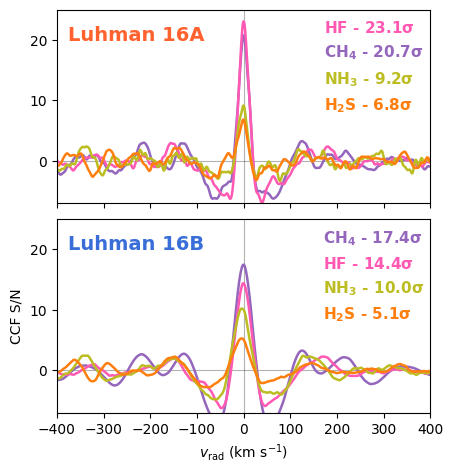

(15.323633353069294, 26.421476621081837)

In [ ]:
color_m_A = '#FF622E'; color_m_B = '#396ED8'
#color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1', '13CO':'C5', 'H2(18)O':'C7', 'C18O':'C9'}
color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1', '13CO':'C5', 'H2(18)O':'C9', 'C18O':'maroon'}
lw = 1.8

species_to_plot = {
    'CH4': ('CH4_MM_main_iso', 'CH_4'), 
    'HF': ('HF_main_iso_new', 'HF'), 
    'NH3': ('NH3_coles_main_iso_Sam', 'NH_3'), 
    'H2S': ('H2S_Sid_main_iso', 'H_2S'), 
}

fig = plt.figure(figsize=(4.5,4.8))
gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.08)

ax_A = fig.add_subplot(gs[0,0])
ax_B = fig.add_subplot(gs[1,0])

for i, (ax_i, CCF_i) in enumerate(zip([ax_A,ax_B], [CCF_SNR_A,CCF_SNR_B])):
    
    handles = []; labels = []; SNR_max = []
    for species_j, (line_species_j, label_j) in species_to_plot.items():

        CCF_j = CCF_i[line_species_j]
        SNR_max_j = CCF_j[rv == 0].flatten()[0]
        SNR_max.append(SNR_max_j)

        label_j = r'$\mathrm{\bf '+f'{label_j}'+'}$'
        label_j += ' - {:.1f}'.format(SNR_max_j) + r'${\bf\sigma}$'
        labels.append(label_j)

        ax_i.plot(rv, CCF_j, lw=lw, c=color_species[species_j])
        
        handle_j, = ax_i.plot([np.nan], [np.nan], lw=0.0, c=color_species[species_j])
        handles.append(handle_j)

    new_order = np.argsort(SNR_max)[::-1]
    
    handles = [handles[i] for i in new_order]
    labels = [labels[i] for i in new_order]

    ax_i.legend(
        loc='upper right', bbox_to_anchor=(1.02,1.02), frameon=False, 
        handles=handles, labels=labels, #markerfirst=False, 
        handlelength=0.0, labelcolor='linecolor', 
        prop={'weight':'bold', 'size':11}, 
    )

    #ax_i.set(xlim=(-250,250), ylim=(-7,21))
    ax_i.set(xlim=(-400,400), ylim=(-7,25))
    ax_i.axhline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)
    ax_i.axvline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)

# Add object name
ann_kwargs = dict(
    xy=(0.03,0.92), xycoords='axes fraction', ha='left', va='top', 
    c=color_m_A, fontsize=14, fontweight='bold', 
)
ax_A.annotate('Luhman 16A', **ann_kwargs)

ann_kwargs['c'] = color_m_B
ax_B.annotate('Luhman 16B', **ann_kwargs)

ax_A.set(xticklabels=[])
ax_B.set(xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', ylabel=r'CCF S/N')

plt.subplots_adjust(left=0.13, bottom=0.12, top=0.96, right=0.96)
plt.savefig(f'./plots/K_band_CCF.pdf')
plt.show()

Res_A.bestfit_params['K2166_A']['vsini'], Res_B.bestfit_params['K2166_B']['vsini']

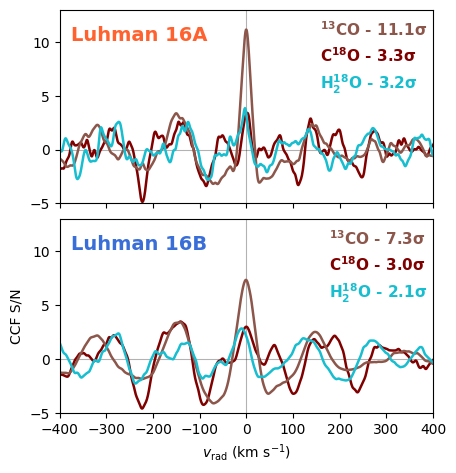

(15.323633353069294, 26.421476621081837)

In [25]:
species_to_plot = {
    'C18O': ('CO_28_high_Sam', 'C^{18}O'), 
    '13CO': ('CO_36_high_Sam', '^{13}CO'), 
    'H2(18)O': ('H2O_181_HotWat78', 'H_2^{18}O'), 
}

fig = plt.figure(figsize=(4.5,4.8))
gs = fig.add_gridspec(nrows=2, ncols=1, hspace=0.08)

ax_A = fig.add_subplot(gs[0,0])
ax_B = fig.add_subplot(gs[1,0])

for i, (ax_i, CCF_i) in enumerate(zip([ax_A,ax_B], [CCF_SNR_A,CCF_SNR_B])):
    
    handles = []; labels = []; SNR_max = []
    for species_j, (line_species_j, label_j) in species_to_plot.items():

        CCF_j = CCF_i[line_species_j]
        SNR_max_j = CCF_j[rv == 0].flatten()[0]
        SNR_max.append(SNR_max_j)

        label_j = r'$\mathrm{\bf '+f'{label_j}'+'}$'
        label_j += ' - {:.1f}'.format(SNR_max_j) + r'${\bf\sigma}$'
        labels.append(label_j)

        ax_i.plot(rv, CCF_j, lw=lw, c=color_species[species_j])
        
        handle_j, = ax_i.plot([np.nan], [np.nan], lw=0.0, c=color_species[species_j])
        handles.append(handle_j)

    new_order = np.argsort(SNR_max)[::-1]
    
    handles = [handles[i] for i in new_order]
    labels = [labels[i] for i in new_order]

    ax_i.legend(
        loc='upper right', bbox_to_anchor=(1.02,1.02), frameon=False, 
        handles=handles, labels=labels, #markerfirst=False, 
        handlelength=0.0, labelcolor='linecolor', 
        prop={'weight':'bold', 'size':11}, 
    )

    #ax_i.set(xlim=(-250,250), ylim=(-7,21))
    ax_i.set(xlim=(-400,400), ylim=(-5,13))
    #ax_i.set(xlim=(-100,100), ylim=(-5,13))
    ax_i.axhline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)
    ax_i.axvline(0, lw=0.8, c='k', zorder=-1, alpha=0.3)

# Add object name
ann_kwargs = dict(
    xy=(0.03,0.92), xycoords='axes fraction', ha='left', va='top', 
    c=color_m_A, fontsize=14, fontweight='bold', 
)
ax_A.annotate('Luhman 16A', **ann_kwargs)

ann_kwargs['c'] = color_m_B
ax_B.annotate('Luhman 16B', **ann_kwargs)

ax_A.set(xticklabels=[])
ax_B.set(xlabel=r'$v_\mathrm{rad}\ (\mathrm{km\ s^{-1}})$', ylabel=r'CCF S/N')

plt.subplots_adjust(left=0.13, bottom=0.12, top=0.96, right=0.96)
plt.savefig(f'./plots/K_band_CCF.pdf')
plt.show()

Res_A.bestfit_params['K2166_A']['vsini'], Res_B.bestfit_params['K2166_B']['vsini']